In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg as la
import scipy.integrate as integrate
import kwant
from scipy.linalg import ishermitian

sigmax = np.array([[0., 1.],[1., 0.]])
sigmay = np.array([[0., -1j*1.],[1j*1., 0.]])
sigmaz = np.array([[1., 0.],[0., -1.]])


In [3]:
def halfBHZham(m, A, B, Lx, Ly):
    h = []
    for i in range(Lx*Ly):
        ix = int(i/Lx)
        iy = i%Ly
        row = []
        for j in range(Lx*Ly):
            jx = int(j/Lx)
            jy = j%Ly
            if(ix==jx and iy==jy):
                row.append(m*sigmaz - 4*B*sigmaz)
                
            elif (jx == ix+1 and iy==jy):   # hop in +x
                row.append(-B*sigmaz - 1j*(A/2)*sigmax)
                
            elif (jx == ix-1 and iy==jy): # hop in -x
                row.append(-B*sigmaz + 1j*(A/2)*sigmax)

            elif (jy == iy+1 and ix==jx):   # hop in +y
                row.append( -B*sigmaz - 1j*(A/2)*sigmay)

            elif (jy == iy-1 and ix==jx):   # hop in -y
                row.append( -B*sigmaz + 1j*(A/2)*sigmay)
                
            else:
                row.append(np.zeros((2,2), dtype=complex))
        h.append(row)
    return np.block(h)
            

In [140]:
halfBHZham(1, 1, 1, 3, 3).shape

(18, 18)

In [4]:
def calculate_bott(H, Lx, Ly, ndof=2):
    L = Lx * Ly
    dim = ndof * L

    # --- Site coordinates (1D arrays) ---
    cell_x = np.zeros(dim, dtype=int)
    cell_y = np.zeros(dim, dtype=int)

    for x in range(Lx):
        for y in range(Ly):
            i = x * Ly + y
            for sub in range(ndof):
                idx = ndof * i + sub
                cell_x[idx] = x
                cell_y[idx] = y

    # --- Diagonalize Hamiltonian ---
    evals, evecs = la.eigh(H)

    # --- Projector onto occupied states ---
    occupied = evals < 0
    P = evecs[:, occupied] @ evecs[:, occupied].conj().T

    # --- Unitary position operators ---
    theta = (2.0 * np.pi / Lx) * cell_x
    phi_b = (2.0 * np.pi / Ly) * cell_y
    Ux = np.diag(np.exp(1j * theta))
    Uy = np.diag(np.exp(1j * phi_b))

    # --- Projected unitaries ---
    U = P @ Ux @ P
    V = P @ Uy @ P

    # --- Bott Operator ---
    W = V @ U @ V.conj().T @ U.conj().T

    # --- Bott index ---
    eigvals_W = la.eigvals(W)
    trace_log = np.sum(np.log(eigvals_W[np.abs(eigvals_W) > 1e-12]))
    bott_index = np.imag(trace_log) / (2 * np.pi)

    return bott_index

In [11]:
Lx = 15
Ly = 15
A = 1
B = 1

var = np.arange(-1,9,0.2)
bi = [calculate_bott(halfBHZham(i, A, B, Lx, Ly), Lx, Ly) for i in var]

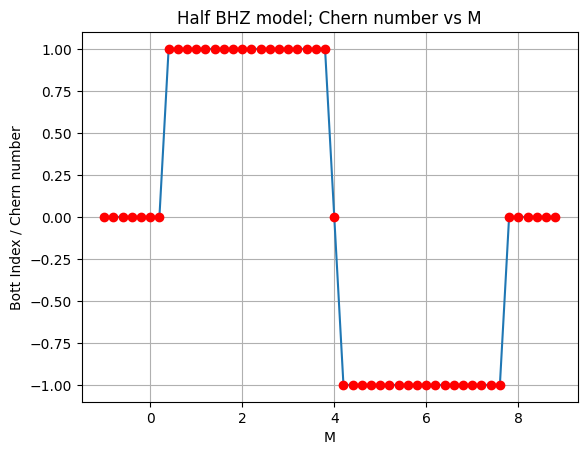

In [28]:
plt.plot(var, bi)
plt.plot(var, bi, 'ro')
plt.grid()
plt.ylabel('Bott Index / Chern number')
plt.xlabel('M')
plt.title('Half BHZ model; Chern number vs M')
plt.show()